In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [5]:
d = pd.read_pickle('hourlies.pickle')

In [6]:
#Prepare numvars for Regression, include both AltimeterSetting and StationPressure
numvars = d.loc[:,['ELEVATION','DATE', 'LATITUDE','HOURLYDRYBULBTEMPF', 'HOURLYDewPointTempF',
                   'HOURLYRelativeHumidity', 'HOURLYWindSpeed','HOURLYStationPressure',
                   'HOURLYAltimeterSetting', 'HOURLYPrecip']]

In [7]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split

In [8]:
#Try to predict Temperature
X = numvars.loc[:,['HOURLYWindSpeed','HOURLYRelativeHumidity','ELEVATION', 'LATITUDE', 'HOURLYStationPressure',
                    'HOURLYAltimeterSetting', 'HOURLYPrecip']]
y = numvars['HOURLYDRYBULBTEMPF']

In [9]:
#make train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
lm = LinearRegression(normalize = True)

In [12]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [13]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
HOURLYWindSpeed,-0.344546
HOURLYRelativeHumidity,-0.365859
ELEVATION,-0.067664
LATITUDE,-1.560593
HOURLYStationPressure,-18.391523
HOURLYAltimeterSetting,-4.856323
HOURLYPrecip,0.002202


In [14]:
predictions = lm.predict( X_test)

This model appears to be quite terrible for predictions, although HourlyAltimeterSetting and Latitude do appear to hold some weight in the model.

In [15]:
print('MSE:', mean_squared_error(y_test, predictions))
print('R2:', r2_score(y_test, predictions))
print('FVE:', explained_variance_score(y_test, predictions))

MSE: 294.7082693889124
R2: 0.3650156418017403
FVE: 0.3650166599575909


In [16]:
#Let's see what Ridge comes up with
from sklearn.linear_model import Ridge, RidgeCV

In [17]:
#make some alphas
alphas = np.linspace(0.001, 200, 100)

In [18]:
ridge = Ridge(normalize = True)

In [20]:
#Store selection of coefs
coef = []
for i in alphas:
    ridge.set_params(alpha = i)
    ridge.fit(X,y)
    coef.append(ridge.coef_)

Text(0,0.5,'weights on coefficients')

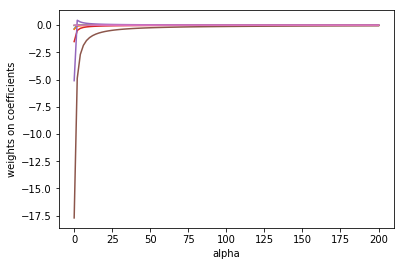

In [21]:
#Plot the coefficients for values of alhpa
ax = plt.gca()
ax.plot(alphas, coef)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights on coefficients')


In [22]:
#Choose the best alpha with cross validation
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', 
                  normalize = True)
ridgecv.fit(X_train, y_train)
bestalpha = ridgecv.alpha_

In [23]:
print(f'bestalpha:',bestalpha)
ridge.set_params(alpha = bestalpha)
ridge.fit(X,y)
ridge.coef_

bestalpha: 0.001


array([-3.46688127e-01, -3.75676004e-01, -2.45728865e-02, -1.50949129e+00,
       -5.10217161e+00, -1.77125731e+01,  2.21672365e-03])

In [24]:
from sklearn.linear_model import Lasso, LassoCV

In [25]:
lasso = Lasso(max_iter = 1000, normalize = True)
coef_lasso = []
alphas = np.linspace(0.001, 200, 100)

In [26]:
for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    

Text(0,0.5,'weights on coefficients')

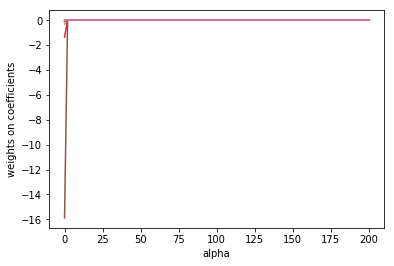

In [27]:
ax = plt.gca()
ax.plot(alphas, coef_lasso)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights on coefficients')

In [28]:
#cross validation on alpha
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 1000, normalize = True)
lassocv.fit(X_train, y_train)

LassoCV(alphas=array([1.00000e-03, 2.02119e+00, ..., 1.97980e+02, 2.00000e+02]),
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [29]:
lasso.set_params(alpha = lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

302.35396940966626

In [30]:
pd.Series(lasso.coef_, index = X.columns)

HOURLYWindSpeed           -0.085195
HOURLYRelativeHumidity    -0.299911
ELEVATION                 -0.006102
LATITUDE                  -1.356189
HOURLYStationPressure      0.000000
HOURLYAltimeterSetting   -15.890607
HOURLYPrecip               0.000000
dtype: float64

The lasso results are a little more interesting and indicate that StationPressure, Precip, and Elevation (to some extent) have little effect on the (already poor) linear model.  Let's try simple linear regression again, but this time by those variables and separate the locations to see if we can get better results. 

In [31]:
coef_linear = []
MSEs = []
fves = []
locations = list(np.unique(d.index))
locations

['AKRON CANTON AIRPORT OH US',
 'ALAMOSA SAN LUIS VALLEY REGIONAL AIRPORT CO US',
 'ALBUQUERQUE INTERNATIONAL AIRPORT NM US',
 'BEND MUNICIPAL AIRPORT OR US',
 'BURLINGTON WEATHER SERVICE OFFICE AIRPORT VT US',
 'CARIBOU WEATHER FORECAST OFFICE ME US',
 'CHARLESTON INTL. AIRPORT SC US',
 'DETROIT CITY AIRPORT MI US',
 'GRAND FORKS INTERNATIONAL AIRPORT ND US',
 'GREAT FALLS AIRPORT MT US',
 'HOUSTON WILLIAM P HOBBY AIRPORT TX US',
 'HUNTSVILLE INTERNATIONAL AIRPORT JONES FIELD AL US',
 'JACKSONVILLE INTERNATIONAL AIRPORT FL US',
 'MERCURY DESERT ROCK AIRPORT NV US',
 'MINNEAPOLIS ST PAUL INTERNATIONAL AIRPORT MN US',
 'NEW ORLEANS AIRPORT LA US',
 'POCATELLO REGIONAL AIRPORT ID US',
 'SEATTLE TACOMA INTERNATIONAL AIRPORT WA US',
 'WICHITA DWIGHT D. EISENHOWER NATIONAL AIRPORT KS US']

In [32]:
for state in locations:
    X = numvars.loc[state,['HOURLYRelativeHumidity', 'HOURLYWindSpeed',
                   'LATITUDE','HOURLYAltimeterSetting']]
    y = numvars.loc[state,'HOURLYDRYBULBTEMPF']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    linear = LinearRegression(normalize = True)
    linear.fit(X_train, y_train)
    coef_linear.append(linear.coef_)
    predictions = linear.predict(X_test)
    MSEs.append(mean_squared_error(y_test, predictions))
    fves.append(explained_variance_score(y_test, predictions))


In [33]:
print(MSEs)

[339.2469815661278, 261.8768709950602, 231.6221142366207, 100.82722495865218, 408.15642860307355, 428.54736705117125, 175.1977781120756, 351.58920542778384, 441.2490065311388, 244.59800321540098, 105.74483725047915, 216.58992613782289, 121.15637110631228, 185.65079752543568, 418.4423234139962, 112.00943376749733, 169.1666885007337, 81.2299273481259, 294.1159403554994]


In [34]:
print(fves)

[0.13545534059711073, 0.4667874893780033, 0.2623270314763366, 0.686313928469451, 0.05632162521990691, 0.014558014887673831, 0.14670940830297718, 0.13280911955209973, 0.28494163217485247, 0.4641427961861322, 0.3951093025874274, 0.20151141991088206, 0.2319462066050807, 0.4658964947816442, 0.20337500168751288, 0.3257189195518998, 0.6171223194275703, 0.3696635572935597, 0.26666258996651526]


In [35]:
print(f'It seems like the linear model at {locations[3]} may hold some promise, but several were terrible, including {locations[4]} and {locations[5]}')

It seems like the linear model at BEND MUNICIPAL AIRPORT OR US may hold some promise, but several were terrible, including BURLINGTON WEATHER SERVICE OFFICE AIRPORT VT US and CARIBOU WEATHER FORECAST OFFICE ME US


## Conclusion

The results of the Ridge and Lasso appeared to make sense.  From a scientific point of view, I do not understand why AltimeterSetting holds the most weight in a linear model and appears to be correlated with temperature.  It seems that a linear model could produce some results that are better than average in Bend, Oregon.